# Imports

In [135]:
#manipulação de dados
import pandas  as pd
import numpy   as np
import inflection
import regex   as re

#visualização
import seaborn as sns
from matplotlib           import pyplot  as plt
from plotly               import express as px
from IPython.core.display import HTML

#métricas
from yellowbrick.cluster  import KElbowVisualizer, SilhouetteVisualizer
from sklearn              import metrics as m

#modelos
from sklearn              import cluster as c

## Helper funtions

In [136]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Lavin\anaconda3\envs\insiders_clustering\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['re']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# load data

In [137]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv',encoding= 'unicode_escape')

In [138]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [139]:
df1 = df_raw.copy()

**data dimensions**

In [140]:
df1.shape

(541909, 9)

**Rename columns**

In [141]:
old_cols = df1.columns
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase,old_cols))
df1.columns = new_cols

In [142]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country', 'unnamed: 8'],
      dtype='object')

**delete column**

In [143]:
df1.drop(columns='unnamed: 8',inplace=True)

In [144]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## Data types

In [145]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Checking NA

In [146]:
df1.isnull().sum()/len(df_raw)*100

invoice_no       0.000000
stock_code       0.000000
description      0.268311
quantity         0.000000
invoice_date     0.000000
unit_price       0.000000
customer_id     24.926694
country          0.000000
dtype: float64

### replace NA

In [147]:
df1 = df1.dropna(subset=['description','customer_id'])

In [148]:
1- df1.shape[0]/df_raw.shape[0]

0.24926694334288602

In [149]:
df1.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## Chaging types

In [150]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'],format='%d-%b-%y')

In [151]:
df1['invoice_date']

0        2016-11-29
1        2016-11-29
2        2016-11-29
3        2016-11-29
4        2016-11-29
            ...    
541904   2017-12-07
541905   2017-12-07
541906   2017-12-07
541907   2017-12-07
541908   2017-12-07
Name: invoice_date, Length: 406829, dtype: datetime64[ns]

In [152]:
#df1['invoice_no'].astype(int)

'Invoice_no' possui letras em algumas linhas, necessita de limpeza mais detalhada

# Data description

In [153]:
df2 = df1.copy()

# Features enginering

In [154]:
df3 = df2.copy()

In [155]:
df3.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


## Feature creation

In [156]:
df_ref = pd.DataFrame(df3['customer_id'])

In [157]:
df_ref =  df_ref.drop_duplicates(ignore_index=True)

In [158]:
# gross revenue (faturamento) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

#monetery
df_monetary = df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref,df_monetary,on='customer_id',how='left')

#recency
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()- df_recency['invoice_date']).dt.days
df_recency = df_recency.drop(columns = 'invoice_date')
df_ref = pd.merge(df_ref,df_recency,on='customer_id',how='left')


#frequency
df_freq = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref,df_freq,on='customer_id',how='left')


# avf ticket
df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref,df_avg_ticket,on='customer_id',how='left')

In [159]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850.0,5288.63,302,35,16.950737
1,13047.0,3079.10,31,18,15.709694
2,12583.0,7187.34,2,18,28.634821
3,13748.0,948.25,95,5,33.866071
4,15100.0,635.10,330,6,105.850000


In [160]:
df4 = df_ref.copy()

# EDA

In [161]:
df5 = df4.copy()

# Data preparation

In [162]:
df6 = df5.copy()

# Feature selection

In [163]:
df7 = df6.copy()

# Fine tuning

In [164]:
X = df7.drop(columns='customer_id')

In [165]:
clusters = [2,3,4,5,6,7]

## Within-Cluster Sum of Square (WSS)

In [166]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10,max_iter=300,random_state=42)
    #model training
    kmeans.fit(X)
    
    wss.append(kmeans.inertia_)

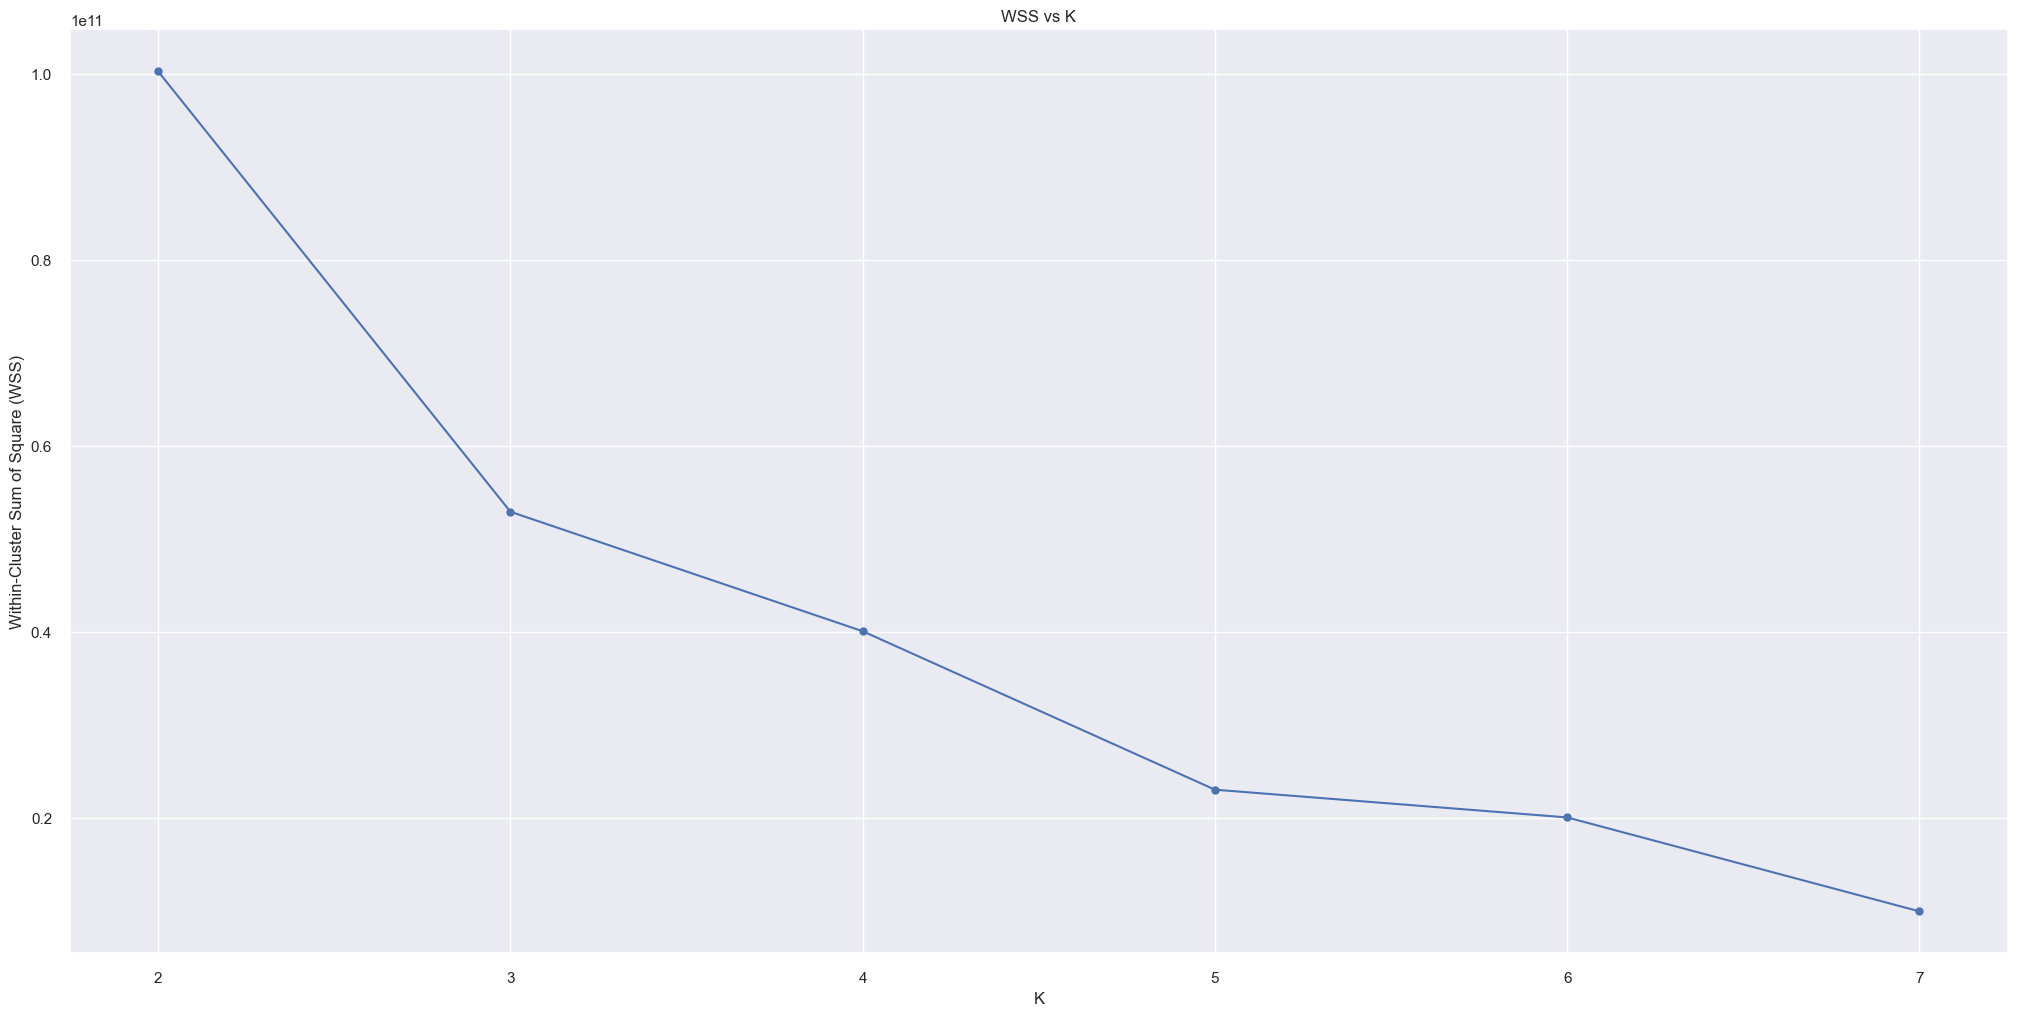

In [167]:
plt.plot(clusters,wss, marker = 'o');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square (WSS)');
plt.title('WSS vs K');

Escolher os pontos com maior variação

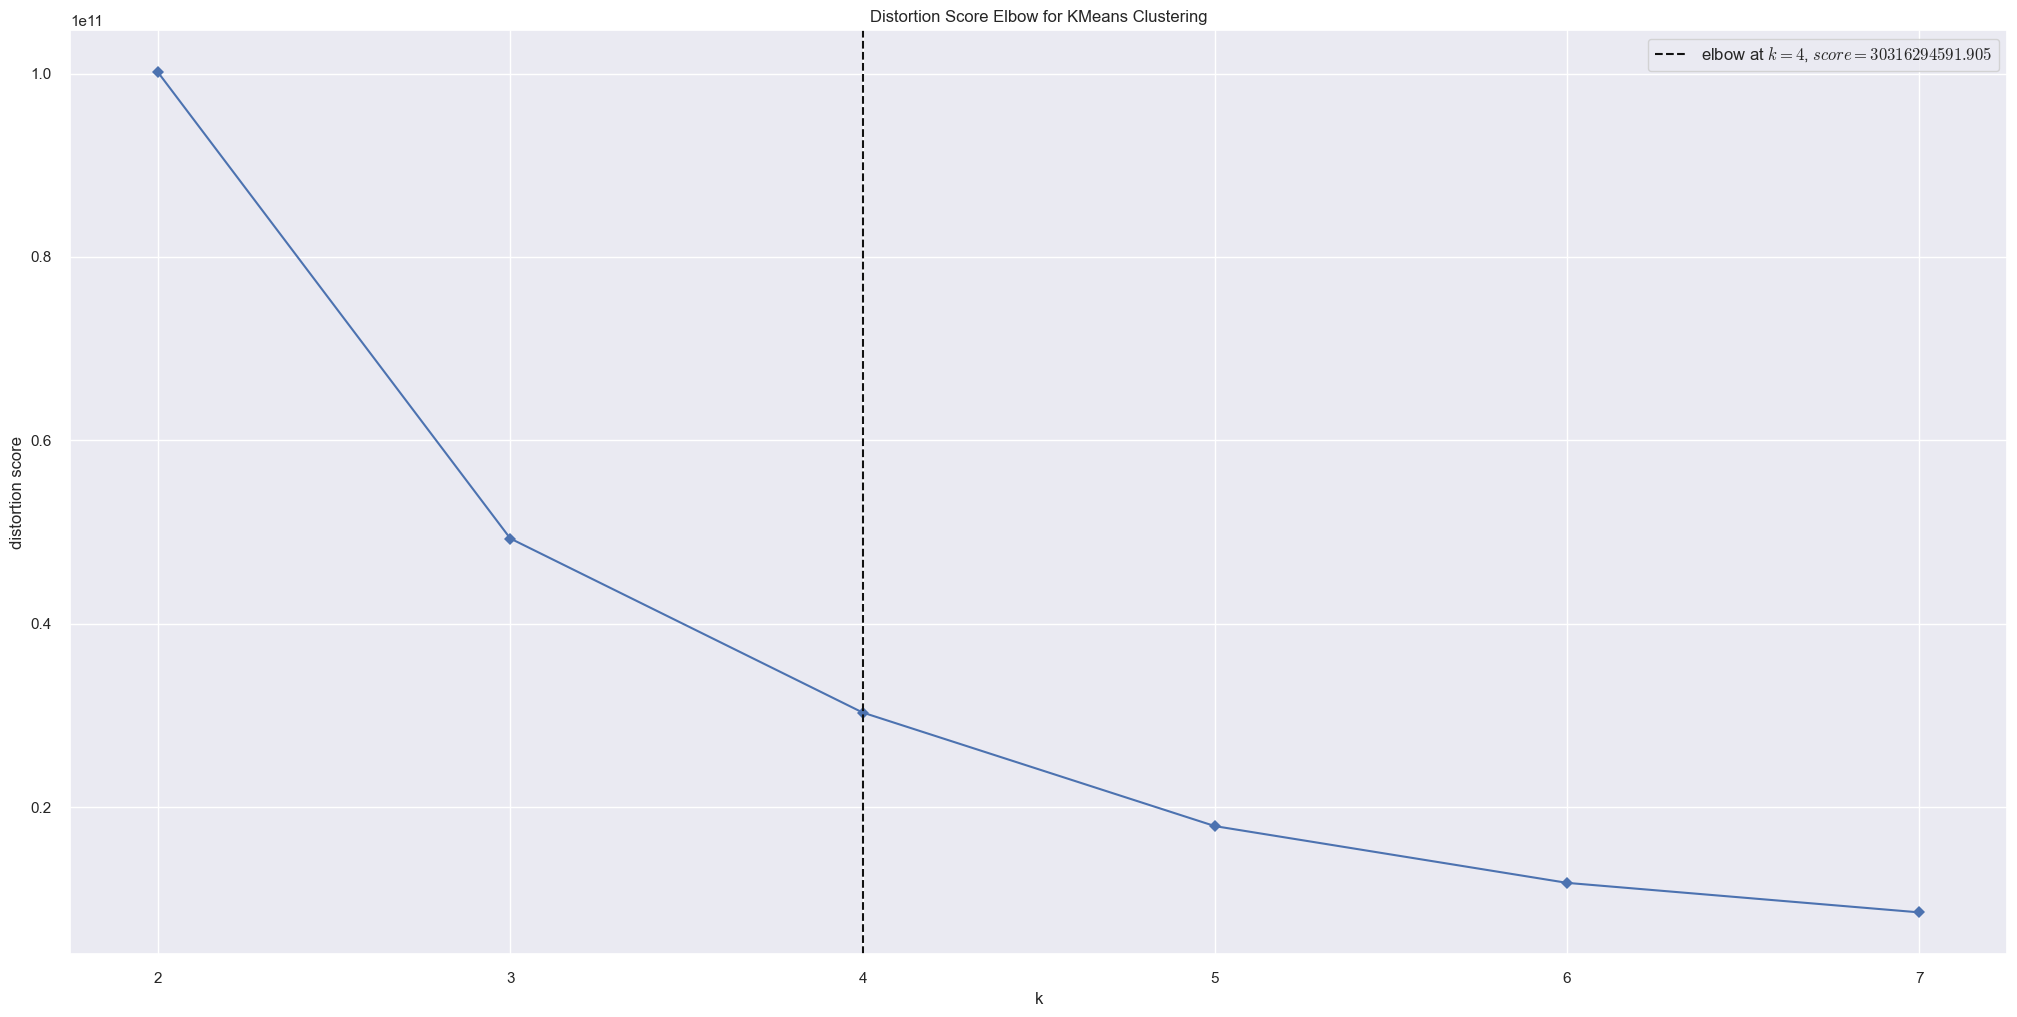

In [168]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

## Sillhouete Score

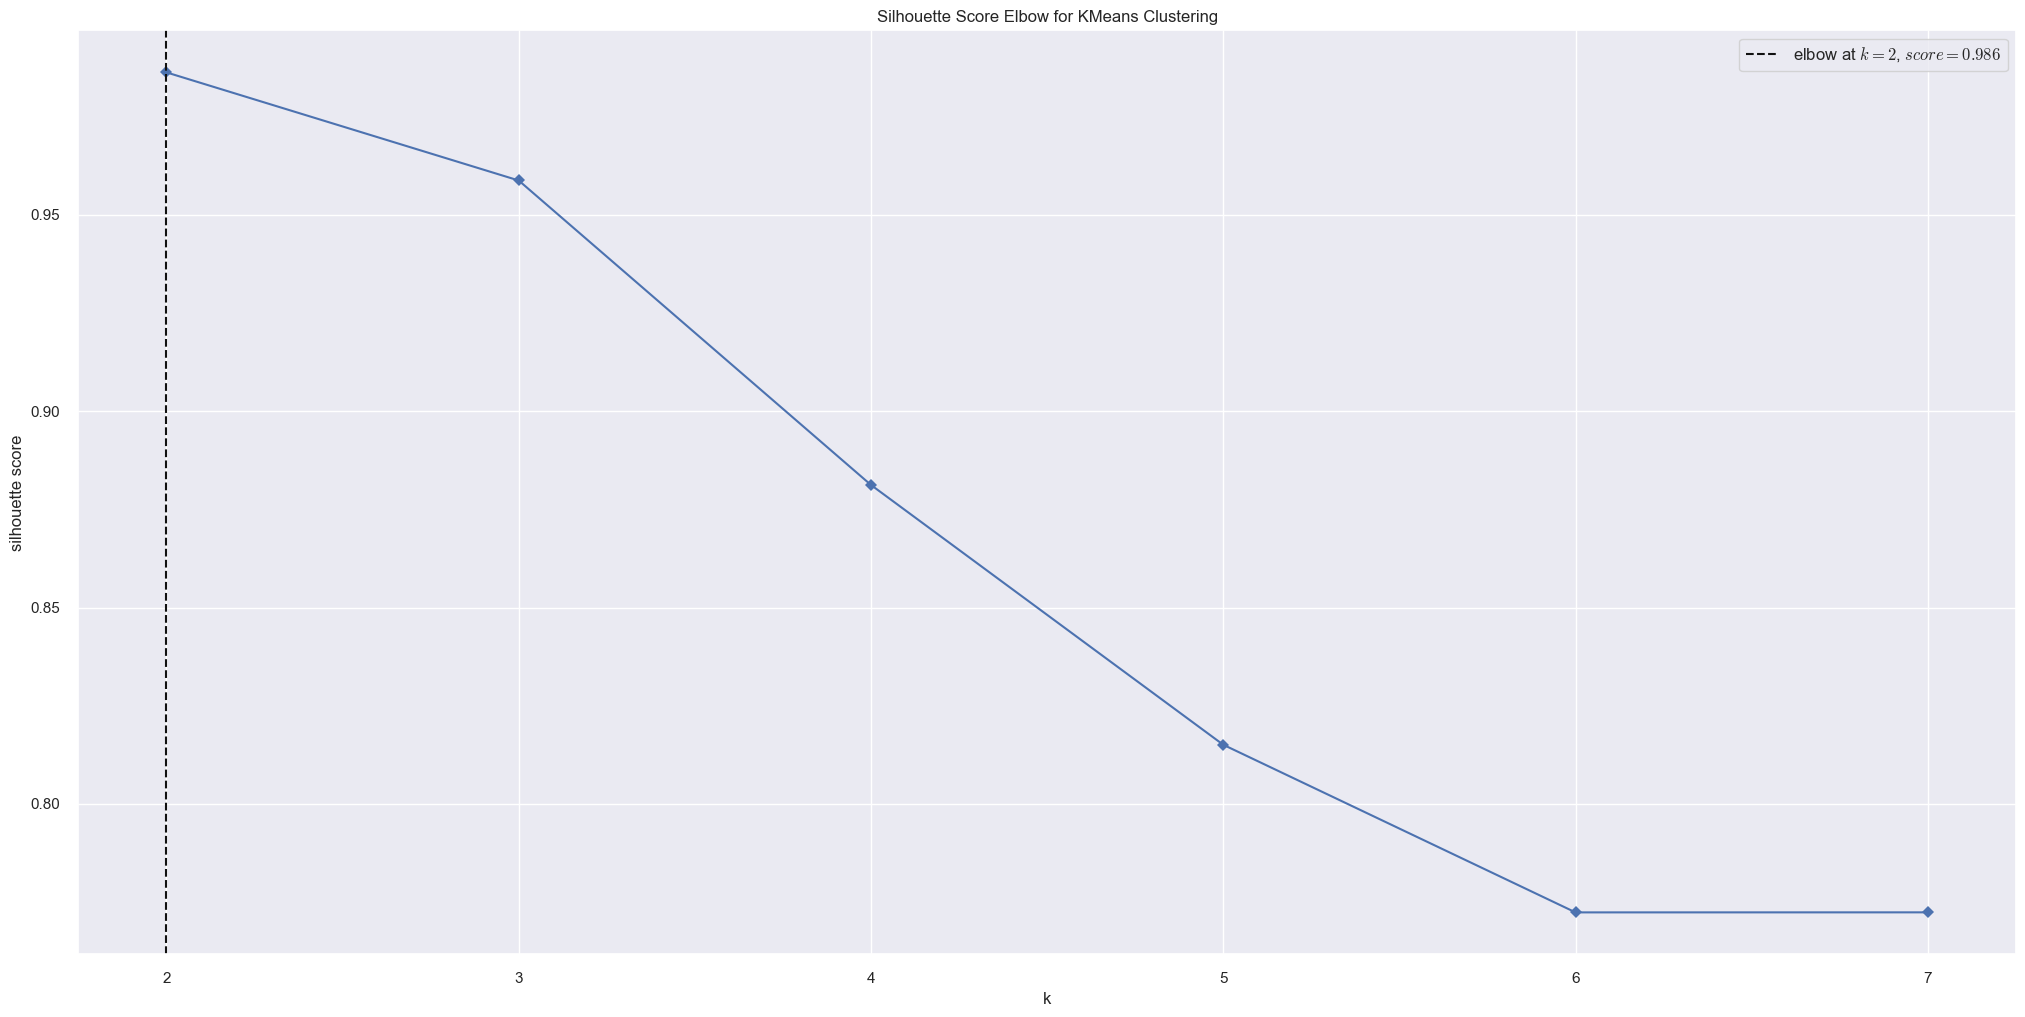

In [169]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

## Silhouete analisys

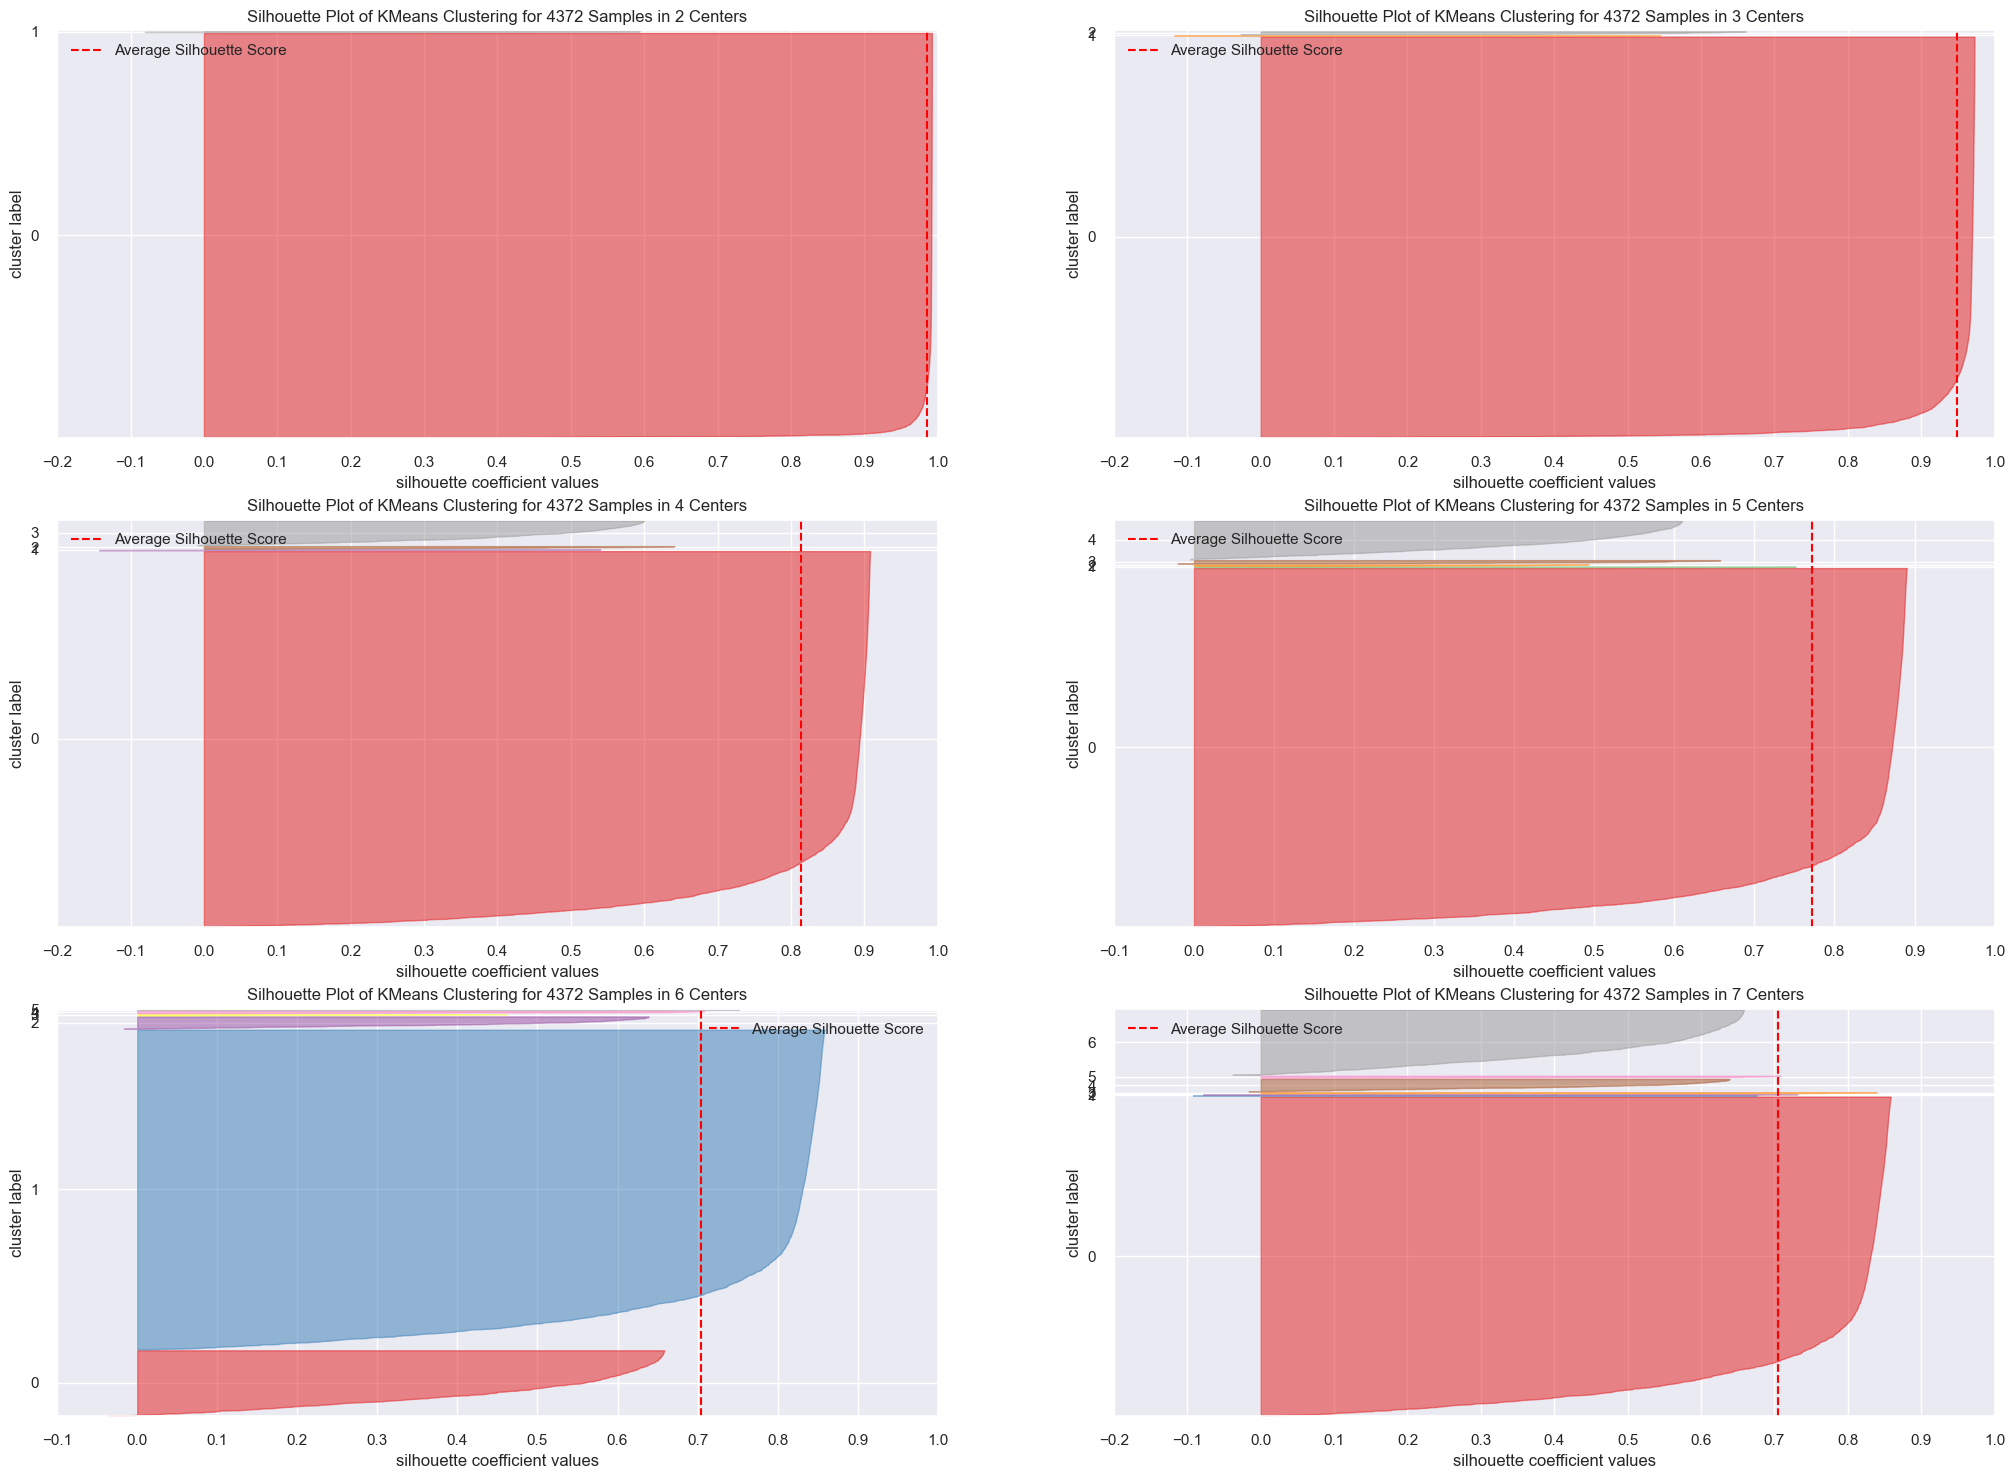

In [170]:
fig, ax = plt.subplots(3,2,figsize=(25,18))
#k=2
for k in clusters:
    km = c.KMeans(n_clusters=k,init='random',n_init=10, max_iter=100,random_state=42)
    l,i = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick',ax=ax[l-1][i])
    visualizer.fit(X)
    visualizer.finalize()

# Model training

## K-means

In [171]:
#model training
k = 4
kmeans = c.KMeans(init='random',n_clusters=k,n_init=10,max_iter=300,random_state=42)
#model training
kmeans.fit(X)
#clustering
labels = kmeans.labels_

### Cluster validation

In [172]:
# WSS
print('WSS value',kmeans.inertia_)

## SS (Silhouette Score)
print('SS value',m.silhouette_score(X,labels,metric='euclidean'))

WSS value 40056506734.60243
SS value 0.8139972028952444


### Cluster analysis

In [173]:
df9 = df7.copy()
df9['clusters'] = labels

C:\Users\Lavin\anaconda3\envs\insiders_clustering\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


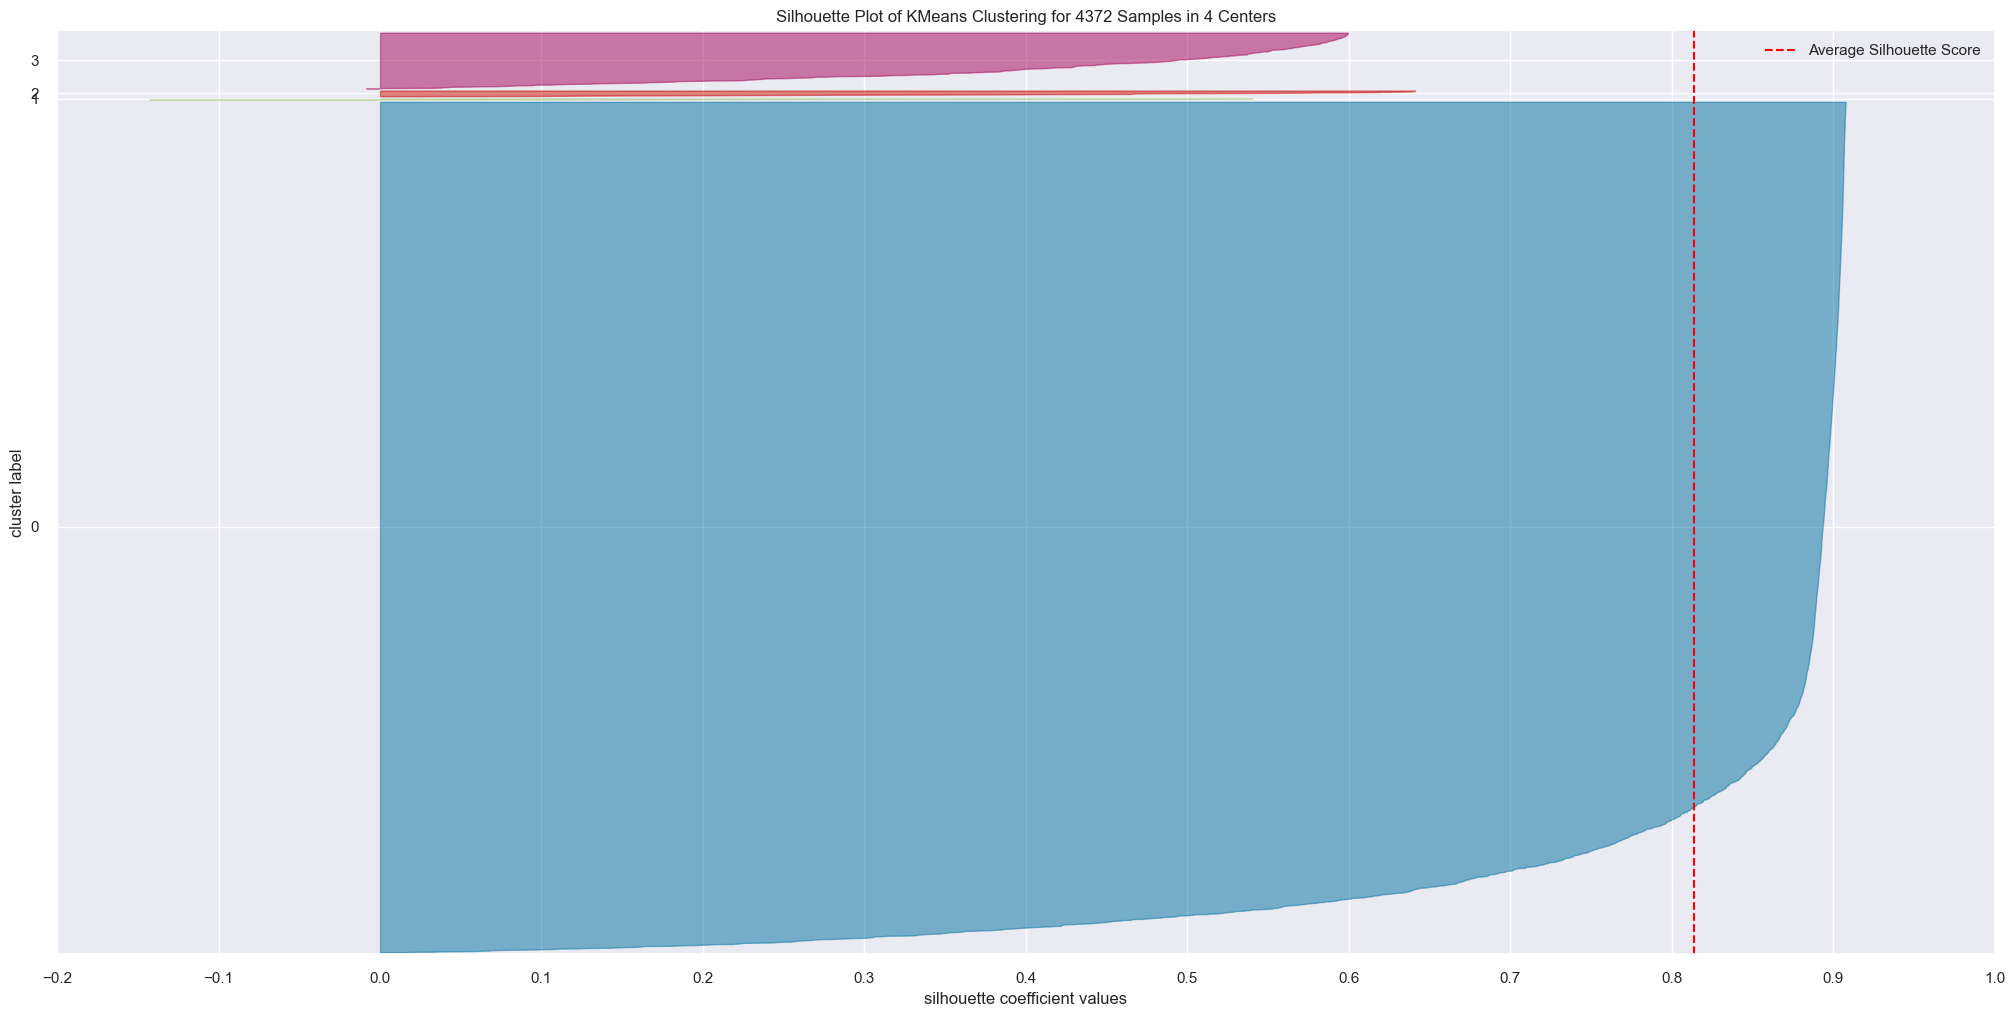

In [174]:
visualizer = SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

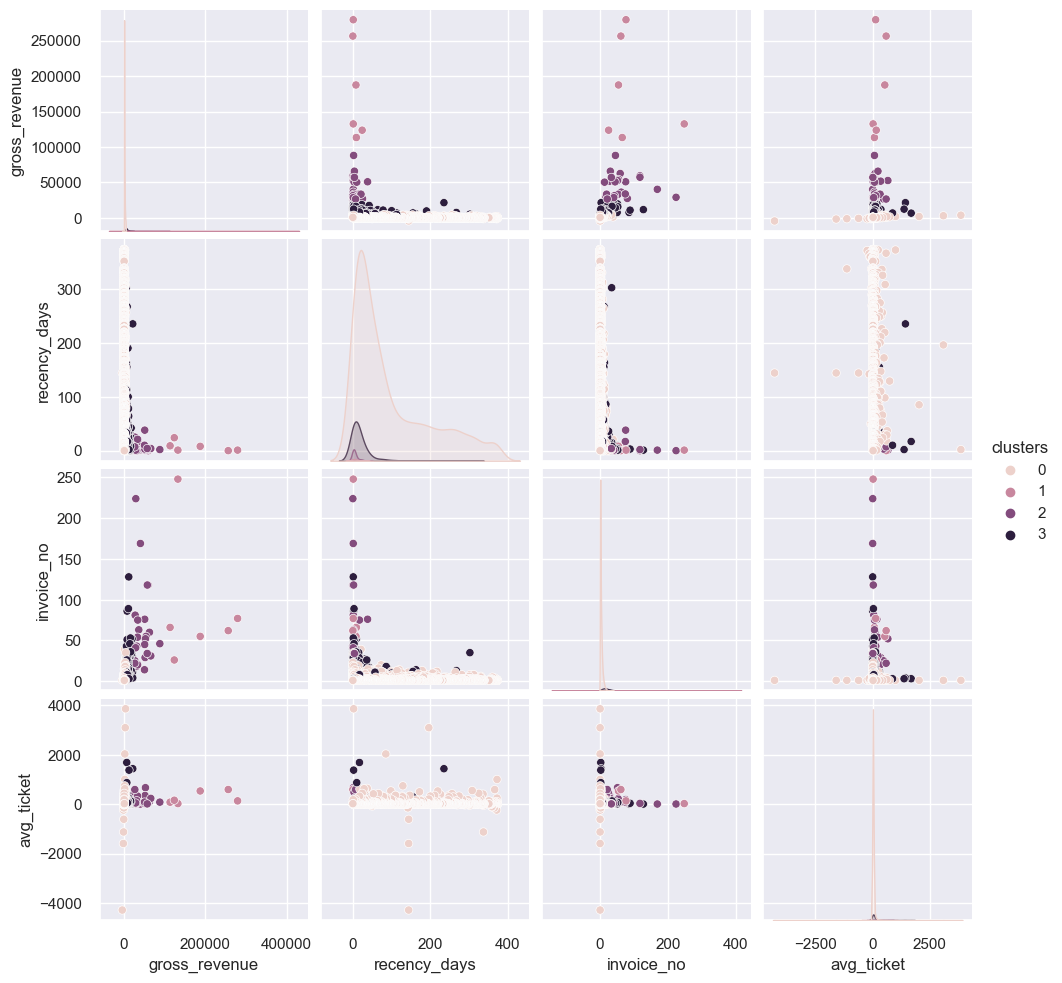

In [175]:
df_viz = df9.drop(columns='customer_id',axis=1)
sns.pairplot(df_viz,hue='clusters')

### UMAP

In [176]:
import umap.umap_ as umap

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

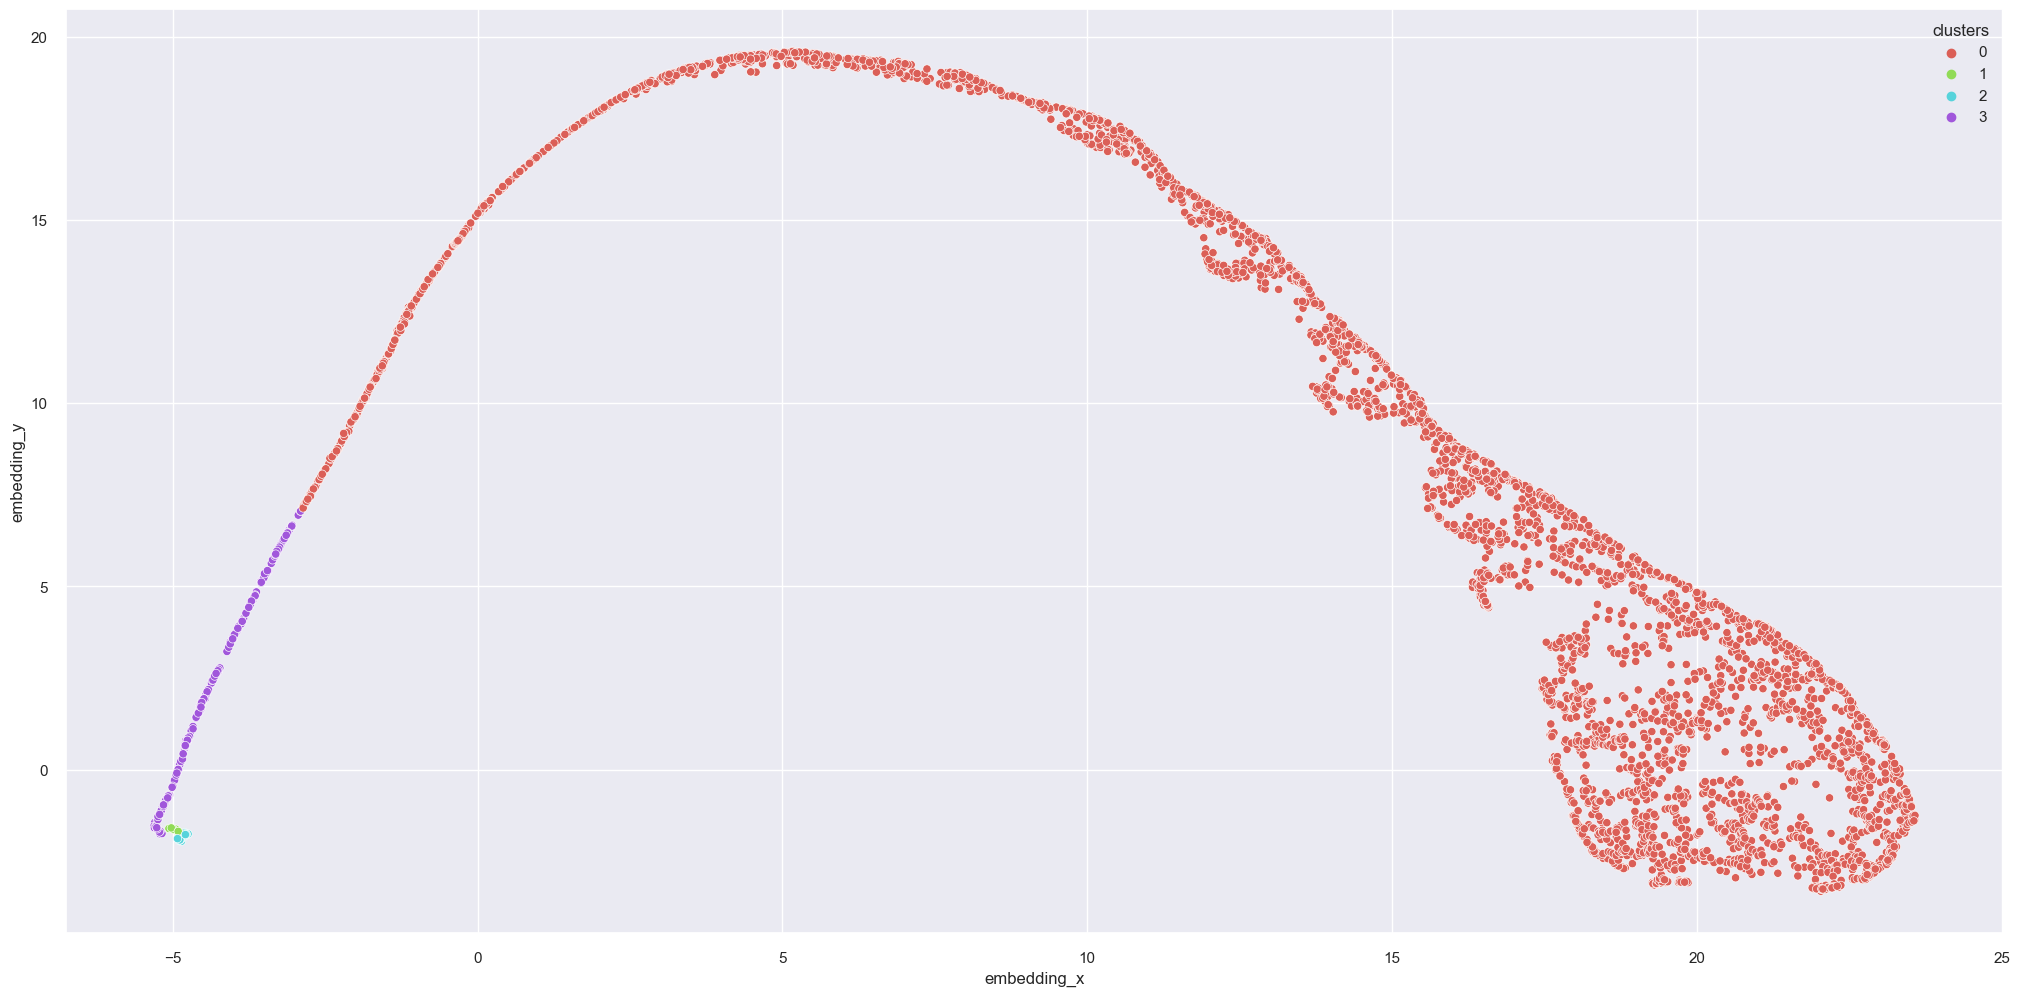

In [177]:
reducer = umap.UMAP(n_neighbors=100,random_state=42)
embedding = reducer.fit_transform(X)

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',hue='clusters', palette=sns.color_palette('hls',n_colors=len(df_viz['clusters'].unique())),data = df_viz)

# Cluster profile

In [178]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,clusters
0,17850.0,5288.63,302,35,16.950737,3
1,13047.0,3079.10,31,18,15.709694,0
2,12583.0,7187.34,2,18,28.634821,3
3,13748.0,948.25,95,5,33.866071,0
4,15100.0,635.10,330,6,105.850000,0


In [179]:
# number of customers
df_cluster = df9[['customer_id','clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100
# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue','clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_gross_revenue,how='inner',on='clusters')

# avg recency days
df_avg_recency_days =  df9[['recency_days','clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_recency_days,how='inner',on='clusters')

# avg invoice no
df_avg_invoice_no =  df9[['invoice_no','clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_invoice_no,how='inner',on='clusters')

df_ticket =  df9[['avg_ticket','clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_ticket,how='inner',on='clusters')

In [180]:
df_cluster

,clusters,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157
